# l1 Trend Filtering

Paper : https://web.stanford.edu/~boyd/papers/pdf/l1_trend_filter.pdf


## Imports

In [1]:
# general imports
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import ruptures as rpt

sns.set_theme()


# from our repo
from datasets.univariate.create_signals import create_signals
from datasets.multivariate.create_multivariate_signals import (
    create_multivariate_signals,
)

from filters.univariate.hodrick_prescott import Hodrick_Prescott
from filters.univariate.l1_trend_filter import l1_trend_filter
from filters.univariate.l1_trend_filter_2 import l1_trend_filter2
from utils.get_breakpoints import get_breakpoints
from utils.get_heuristic_lambda import get_heuristic_lambda
from utils.normalize_signal import normalize_signal
from filters.multivariate.l1_trend_filter_multivariate import (
    l1_trend_filter_multivariate,
)

## Vizualizing trend filtering (univariate)

heuristic lambda : 563.341466310491
Number of breakpoints :  3


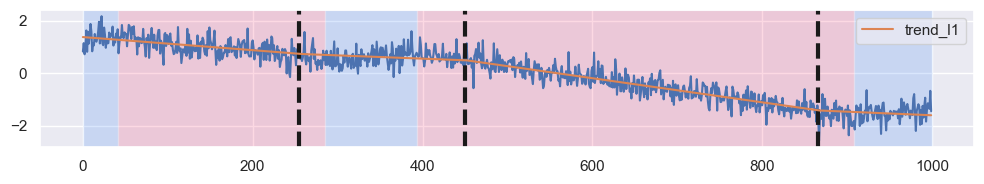

heuristic lambda : 570.4493603609177
Number of breakpoints :  4


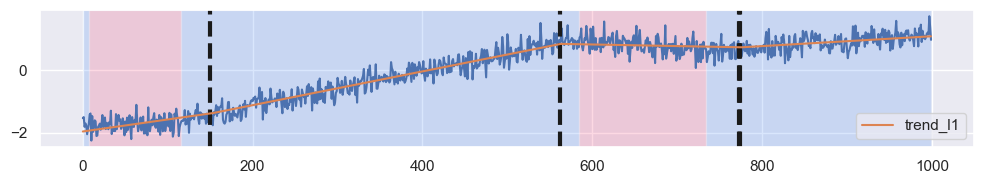

heuristic lambda : 853.2941950730064
Number of breakpoints :  6


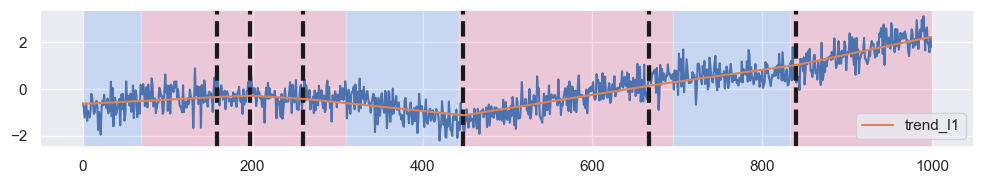

heuristic lambda : 1121.064888553715
Number of breakpoints :  5


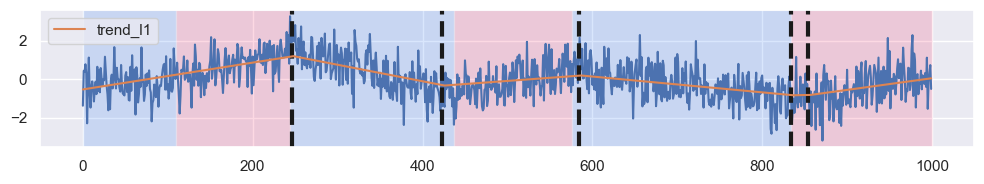

heuristic lambda : 799.3984688108972
Number of breakpoints :  4


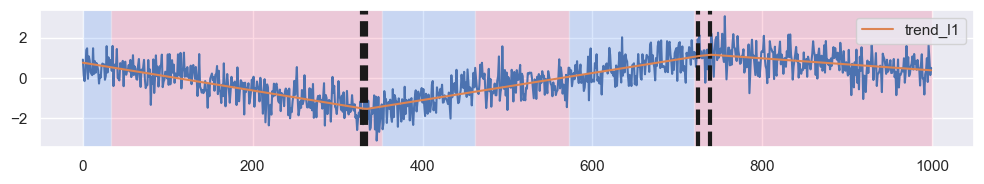

In [31]:
N_signals = 5

# Create synthetic piecewise linear signals with noise
signals, breakpoints_list = create_signals(
    N=N_signals,
    signal_length=1000,
    max_slope=0.5,
    p_trend_change=0.01,
    noise_level=20.0,
)

for i in range(N_signals):
    # signals is of shape (N_signals, signal_length)
    signal = signals[i]
    bkps = breakpoints_list[i]

    # Normalize signal
    signal = normalize_signal(signal)

    # Heuristic to choose lambda value
    penalty = get_heuristic_lambda(signal)
    print("heuristic lambda :", penalty)
    # penalty = 700

    # get the trend from l1_trend_filtering
    trend_l1 = l1_trend_filter(signal, penalty=penalty)

    # get the predicted breakpoints of the filtered trend
    pred_bkps = get_breakpoints(trend_l1)
    print("Number of breakpoints : ", len(pred_bkps))

    # display the predicted changepoints and the trend
    rpt.display(signal, bkps, pred_bkps)
    x_axis = np.arange(len(signal))
    plt.plot(x_axis, trend_l1, label="trend_l1")

    # Benchmark to compare Hodrick_Prescott vs l1_trend_filter
    # trend_HP = Hodrick_Prescott(signal, penalty=penalty)
    # plt.plot(x_axis, trend_HP, label = "trend_HP")

    # Benchmark to show the two equivalent formulations of l1_trend_filtering
    # trend_l1_2 = l1_trend_filter2(signal, penalty=penalty)
    # plt.plot(x_axis, trend_l1_2, label = "trend_l1_2")

    plt.legend()
    plt.show()

## Execution Time

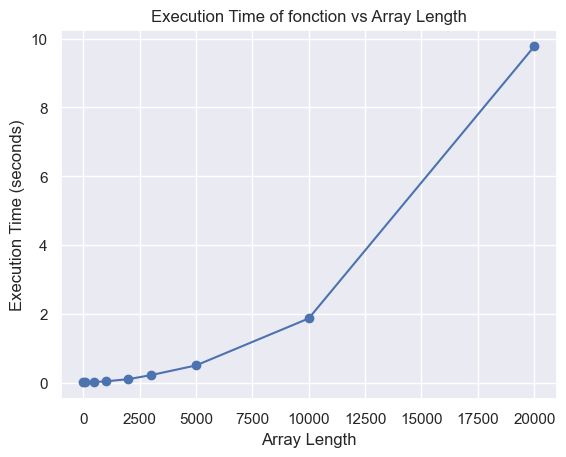

In [2]:
import numpy as np
import timeit
import matplotlib.pyplot as plt


def measure_execution_time(signal_length, N_experiments=5):
    exec_time = 0
    # Input Setup
    signals, breakpoints_list = create_signals(
        N=N_experiments,
        signal_length=signal_length,
        max_slope=0.5,
        p_trend_change=0.01,
        noise_level=20.0,
    )
    # Measure execution time
    for i in range(N_experiments):
        signal = signals[i]
        start_time = timeit.default_timer()
        trend_l1 = l1_trend_filter(signal, penalty=50000.0)
        end_time = timeit.default_timer()
        exec_time += end_time - start_time
    mean_exec_time = exec_time / N_experiments
    return mean_exec_time


# Define the array lengths for which you want to measure execution time
array_lengths = [10, 100, 500, 1000, 2000, 3000, 5000, 10000, 20000]

# Measure execution time for each array length
execution_times = [measure_execution_time(length) for length in array_lengths]

# Plot the results
plt.plot(array_lengths, execution_times, marker="o")
plt.title("Execution Time of fonction vs Array Length")
plt.xlabel("Array Length")
plt.ylabel("Execution Time (seconds)")
plt.show()

## Vizualize multivariate_filters


### Synthetic dataset

In [23]:
multivariate_signals, breakpoints_list = create_multivariate_signals(
    N=10, signal_length=1000, D=5, max_slope=0.5, p_trend_change=0.01, noise_level=20.0
)

signal = multivariate_signals[0]
bkps = breakpoints_list[0]
signal = normalize_signal(signal)

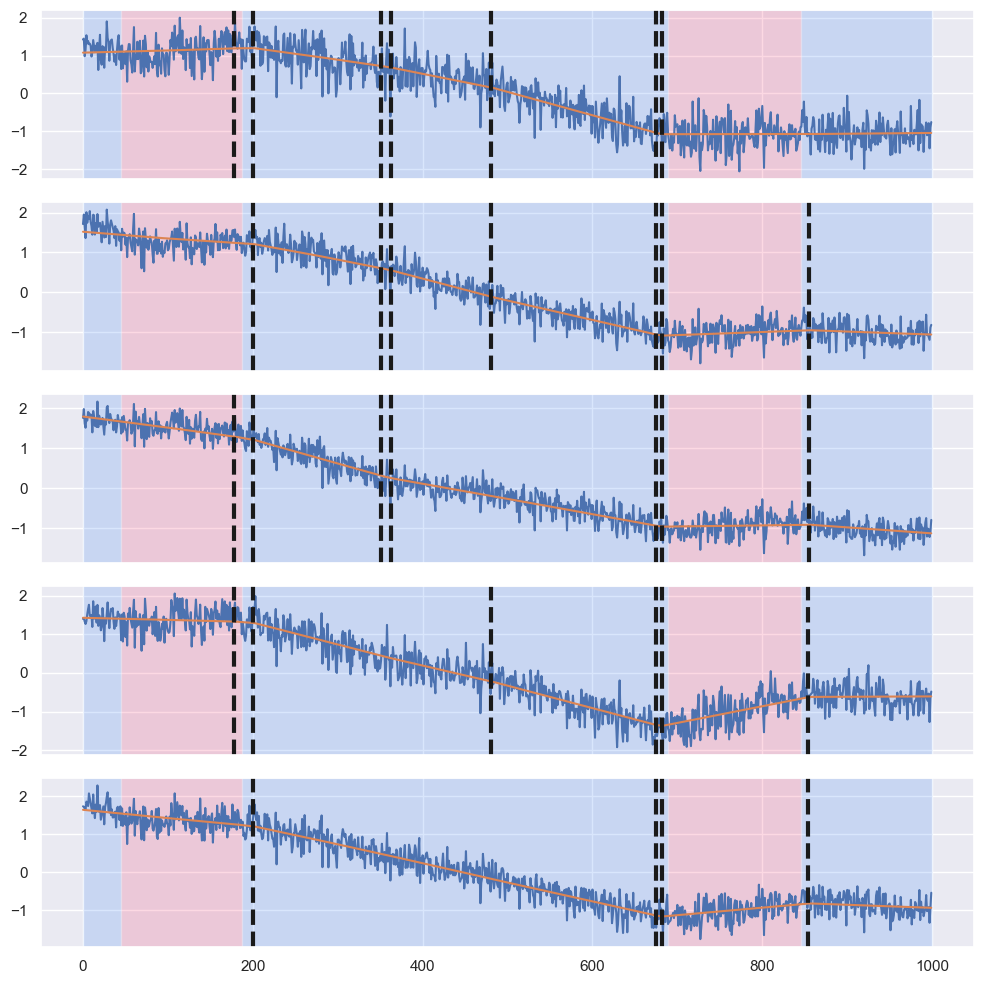

In [25]:
trend_l1 = l1_trend_filter_multivariate(signal, penalty=500)
fig, ax = rpt.display(signal, bkps)
D = 5
for d in range(D):
    pred_bkps = get_breakpoints(trend_l1[:, d])
    ax[d].plot(trend_l1[:, d], label="l1_trend")
    for bkp in pred_bkps:
        ax[d].axvline(
            x=bkp - 0.5,
            color="k",
            linewidth=3,
            linestyle="--",
            alpha=1.0,
        )

### Sensor dataset

#### Visualize the dataset 

(34, 4001, 3)


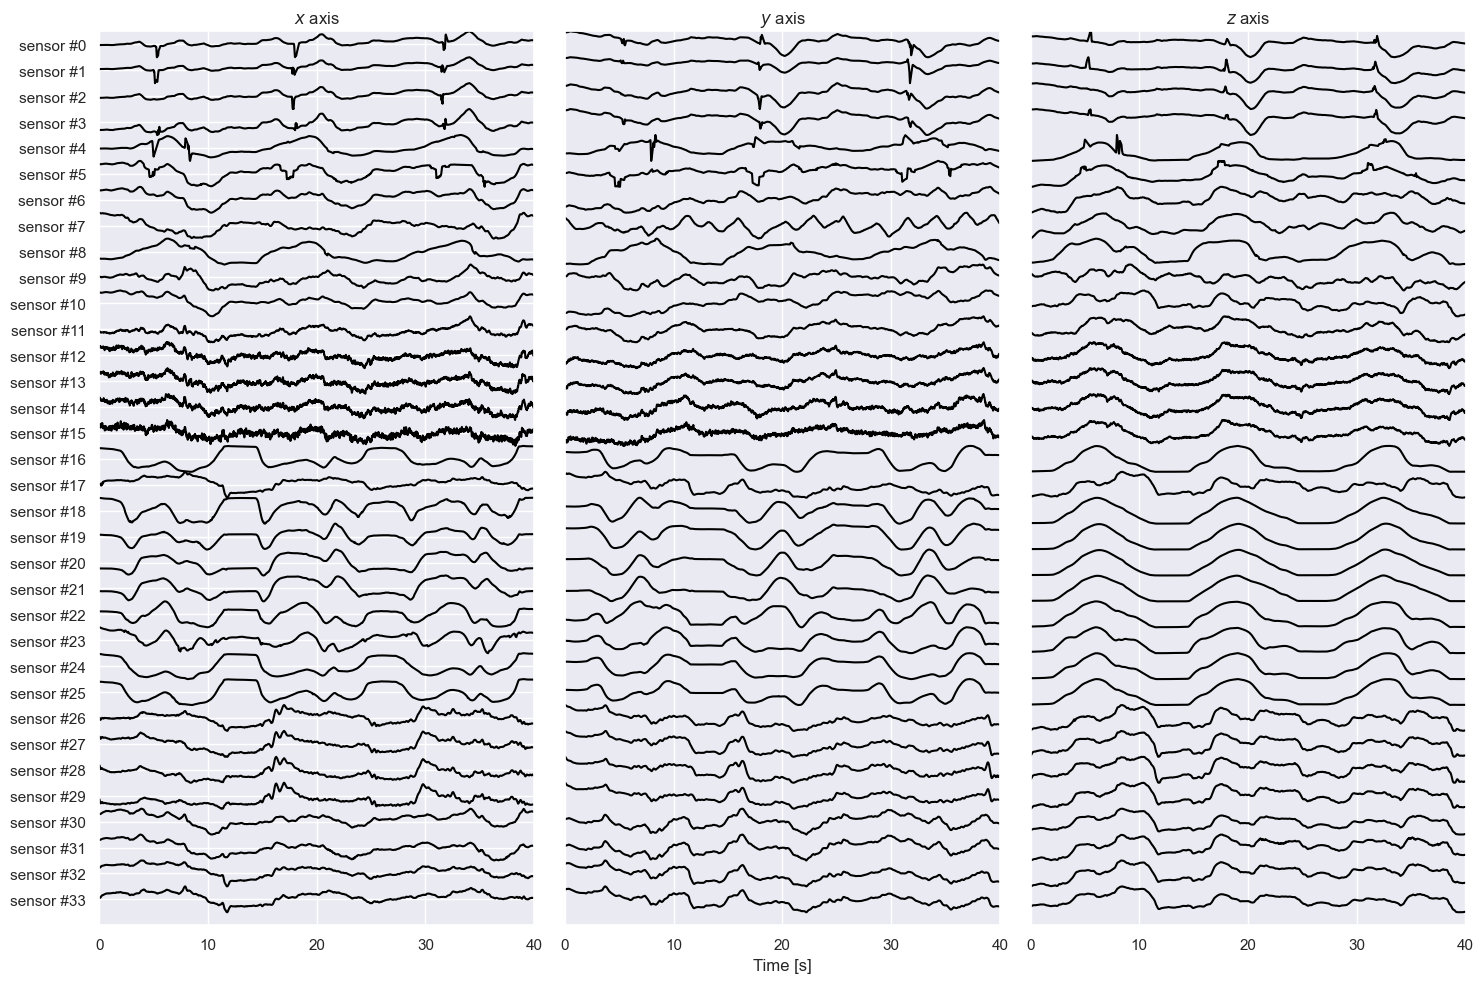

In [19]:
ts = np.load("../../dataset/armcoda_subject1_movement5.npy")
print(ts.shape)

plt.figure(figsize=(15, 10))
names_tick = []
for i in range(len(ts)):
    names_tick.append("sensor #{}".format(i))
    for j in range(3):
        plt.subplot(1, 3, j + 1)
        norm_ts = (ts[i][:, j] - min(ts[i][:, j])) / (
            max(ts[i][:, j]) - min(ts[i][:, j])
        )
        plt.plot(norm_ts - (i + 1.5), color="black")
plt.subplot(1, 3, 1)
plt.xlim(0, len(ts[0]))
plt.ylim(-len(ts) - 1, -0.5)
plt.yticks(list(range(-len(ts), 0))[::-1], names_tick)
plt.xticks([0, 1000, 2000, 3000, 4000], ["0", "10", "20", "30", "40"])
plt.title("$x$ axis")
# plt.tight_layout()

plt.subplot(1, 3, 2)
plt.xlim(0, len(ts[0]))
plt.ylim(-len(ts) - 1, -0.5)
plt.yticks([], [])
plt.xticks([0, 1000, 2000, 3000, 4000], ["0", "10", "20", "30", "40"])
plt.xlabel("Time [s]")
plt.title("$y$ axis")

plt.subplot(1, 3, 3)
plt.xlim(0, len(ts[0]))
plt.ylim(-len(ts) - 1, -0.5)
plt.yticks([], [])
plt.xticks([0, 1000, 2000, 3000, 4000], ["0", "10", "20", "30", "40"])
plt.title("$z$ axis")
plt.tight_layout()
plt.margins(x=0)
plt.show()

#### l1_trend_filtering for 5 different sensors along the z axis 

(4001, 5)


c:\Users\thoma\AppData\Local\Programs\Python\Python39\lib\site-packages\cvxpy\problems\problem.py:158: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "


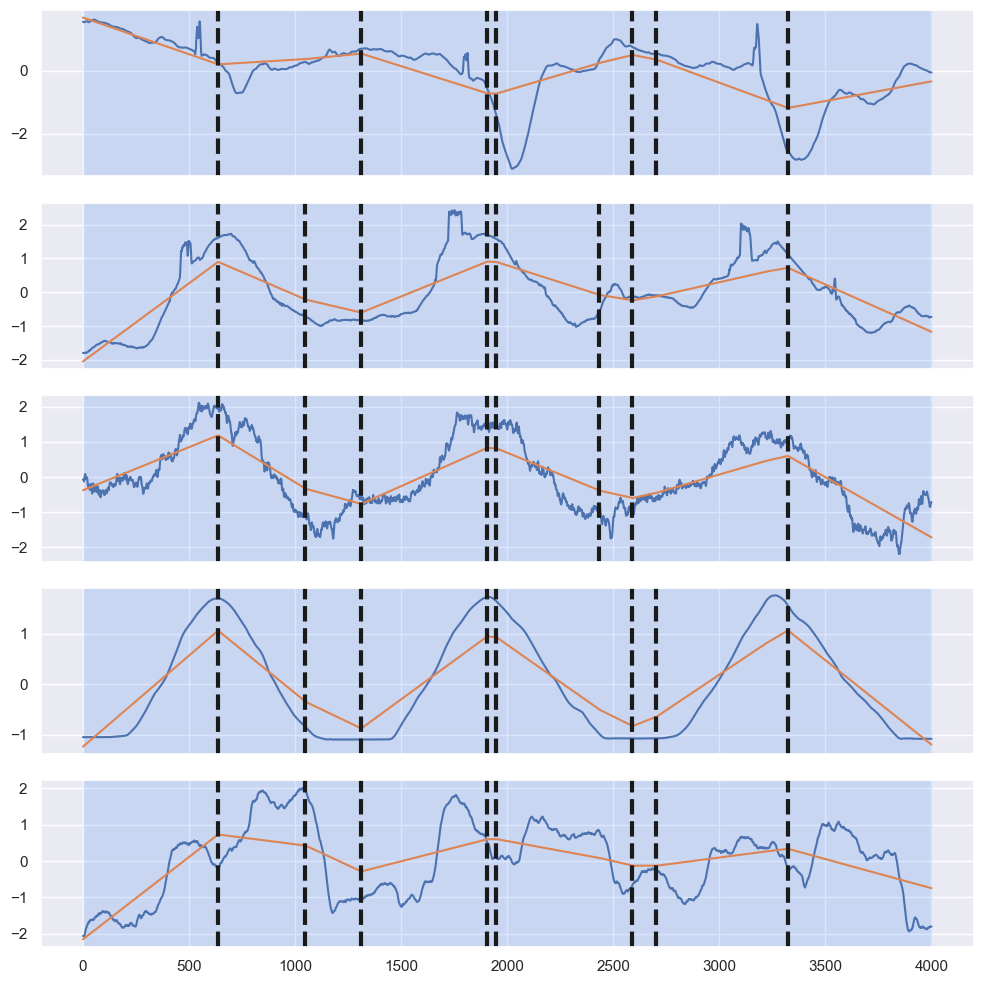

In [22]:
sensor_list = [3, 5, 13, 20, 29]
signal = ts[sensor_list, :, 2]
signal = signal.transpose()
signal = normalize_signal(signal)
print(signal.shape)
bkps = [len(signal)]

trend_l1 = l1_trend_filter_multivariate(signal, penalty=50_000)

fig, ax = rpt.display(signal, bkps)
D = 5
for d in range(D):
    pred_bkps = get_breakpoints(trend_l1[:, d])
    ax[d].plot(trend_l1[:, d], label="l1_trend")
    for bkp in pred_bkps:
        ax[d].axvline(
            x=bkp - 0.5,
            color="k",
            linewidth=3,
            linestyle="--",
            alpha=1.0,
        )